In [14]:
import math
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

## 条件随机场

In [15]:
from typing import Tuple, List
def step(mu_prev: np.ndarray,
         emission_probs: np.ndarray,
         transition_probs: np.ndarray,
         observed_state: int) -> Tuple[np.ndarray, np.ndarray]:
    """Runs one step of the Viterbi algorithm.
    
    Args:
        mu_prev: probability distribution with shape (num_hidden),
            the previous mu
        emission_probs: the emission probability matrix (num_hidden,
            num_observed)
        transition_probs: the transition probability matrix, with
            shape (num_hidden, num_hidden)
        observed_state: the observed state at the current step
    
    Returns:
        - the mu for the next step
        - the maximizing previous state, before the current state,
          as an int array with shape (num_hidden)
    """
    
    pre_max = mu_prev * transition_probs.T
    max_prev_states = np.argmax(pre_max, axis=1)
    max_vals = pre_max[np.arange(len(max_prev_states)), max_prev_states]
    mu_new = max_vals * emission_probs[:, observed_state]
    
    return mu_new, max_prev_states


def viterbi(emission_probs: np.ndarray,
            transition_probs: np.ndarray) -> Tuple[List[int], float]:
    """Runs the Viterbi algorithm to get the most likely state sequence.
    
    Args:
        emission_probs: the emission probability matrix (num_hidden,
            steps)
        transition_probs: the transition probability matrix, with
            shape (steps-1, num_hidden, num_hidden)
    
    Returns:
        - the most likely series of states
        - the joint probability of that series of states and the observed
    """
    
    # Runs the forward pass, storing the most likely previous state.
    assert emission_probs.shape[-1] - 1 == transition_probs.shape[0]
    mu = emission_probs[:, 0]
    all_prev_states = []
    for t in range(1, emission_probs.shape[-1]):
        mu, prevs = step(mu, emission_probs, transition_probs[t-1], t)
        all_prev_states.append(prevs)
    
    # Traces backwards to get the maximum likelihood sequence.
    state = np.argmax(mu)
    sequence_prob = mu[state]
    state_sequence = [state]
    for prev_states in all_prev_states[::-1]:
        state = prev_states[state]
        state_sequence.append(state)
    
    return state_sequence[::-1], sequence_prob

## 报告数据标准化

In [16]:
data = json.load(open('data/conference/conference.json', encoding='utf-8', mode='r'))
reports = []
halls = set()
for report in data:
    title = report['title']
    institutions = report['institutions']
    if title and institutions:
        reports.append(report)
        halls.add(report['hall'])
area1 = ['分会场一', '分会场二', '分会场三', '分会场四', '黄龙水晶宫']
area2 = ['分会场五', '分会场六', '分会场七', '分会场八', '分会场九', '分会场十']
area3 = ['分会场十一', '分会场十二', '分会场十三', '分会场十四']
halls = area1 + area2 + area3
hall_2_id = {h:i for i, h in enumerate(halls)}
id_2_hall = {i:h for h, i in hall_2_id.items()}
print(len(reports), reports[0], halls)
print(hall_2_id)

481 {'date': '2021-10-16 星期六', 'hall': '黄龙水晶宫', 'host': '陆锋', 'topic': '09:10-10:40 | 特邀报告', 'time': '09:10-09:40', 'title': '全球位置服务网关键技术与研究进展', 'reporters': '龚健雅 院士', 'institutions': '武汉大学'} ['分会场一', '分会场二', '分会场三', '分会场四', '黄龙水晶宫', '分会场五', '分会场六', '分会场七', '分会场八', '分会场九', '分会场十', '分会场十一', '分会场十二', '分会场十三', '分会场十四']
{'分会场一': 0, '分会场二': 1, '分会场三': 2, '分会场四': 3, '黄龙水晶宫': 4, '分会场五': 5, '分会场六': 6, '分会场七': 7, '分会场八': 8, '分会场九': 9, '分会场十': 10, '分会场十一': 11, '分会场十二': 12, '分会场十三': 13, '分会场十四': 14}


### 报告时间与会场标准化
需要提一下，有重复报告，这里我们采用去重的方法解决

In [17]:
from datetime import datetime
time_format = '%Y-%m-%d %H:%M'
base_time = datetime(2021, 10, 16)
new_data = []
start_time_set = set()
title_set = set()
for report in reports:
    title = report['title']
    if title in title_set: 
        print(title)
        continue
    title_set.add(title)
    date = report['date']
    time = report['time']
    hall = report['hall']
    topic = report['topic']
    topic = topic.split('|')[-1].split('：')[-1].strip()
    date = date.split(' ')[0]
    start, end = time.split('-')
    start_time = date + ' ' + start # datetime.strptime(date + ' ' + start, time_format)
    end_time = date + ' ' + end
    s_time = datetime.strptime(start_time, time_format) - base_time
    e_time = datetime.strptime(end_time, time_format) -  base_time
    hall_id = hall_2_id[hall]
    report['date'] = date
    report['start_time'] = int(s_time.total_seconds())
    report['end_time'] = int(e_time.total_seconds())
    report['hall_id'] = hall_id
    report['topic'] = topic
    start_time_set.add(start_time)
    new_data.append(report)
json.dump(new_data, open('data/conference/standard_conference_data.json', 'w', encoding='utf-8'), ensure_ascii=False)
print(new_data[0])
print(len(title_set), len(reports))

康巴藏区藏传佛教寺院的空间布局特征及其影响因素
基于GPS轨迹的西藏骑行游客时空行为分析
基于轨迹大数据的游客行为研究：总结、局限与展望
{'date': '2021-10-16', 'hall': '黄龙水晶宫', 'host': '陆锋', 'topic': '特邀报告', 'time': '09:10-09:40', 'title': '全球位置服务网关键技术与研究进展', 'reporters': '龚健雅 院士', 'institutions': '武汉大学', 'start_time': 33000, 'end_time': 34800, 'hall_id': 4}
478 481


#### 按时间段分组

In [31]:
def get_report_groups_by_T(T=600):
    min_delta = T # 600
    all_t_spans, time_spans = [], []
    sorted_data = sorted(new_data, key=lambda x: x['start_time']) # 按开始时间排序
    t = sorted_data[0]['start_time']
    group = 0
    group_dict = defaultdict(lambda: list())
    topic_2_report = defaultdict(lambda: list())
    id_2_report = dict()
    topic_2_report_id = defaultdict(lambda: list())
    for i, report in enumerate(sorted_data):
        s_time = int(report['start_time'])
        e_time = int(report['end_time'])
        topic = report['topic']
        delta = s_time - t
        
        if delta > min_delta:
            group += 1
            t = s_time
            all_t_spans.append(time_spans)
            time_spans = []
        time_spans.append((s_time, e_time))  
        group_dict[group].append(i)   
        report['time_group'] = group
        report['id'] = i
        topic_2_report[topic].append((i, report['title']))
        topic_2_report_id[topic].append(i)
        id_2_report[i] = report['title']
    # print(group)
    json.dump(sorted_data, open(f'data/conference/grouped_conference_data_{min_delta}.json', 'w', encoding='utf-8'), ensure_ascii=False)

    lens = [len(g) for k, g in group_dict.items()]
    group_max_len = max(lens)
    # print(group_max_len, sum(lens) / len(lens), min(lens))
    return sorted_data, topic_2_report_id, group_dict, group_max_len, all_t_spans

# sorted_data, topic_2_report_id, group_dict, group_max_len, all_t_spans = get_report_groups_by_T()

In [19]:
# deltas = []
# bad_cases = []
# good_cases = []
# total = 0
# for i in range(len(all_t_spans)-1):
#     from_t, to_t = all_t_spans[i], all_t_spans[i+1]
#     # avg_from_e_t = sum([et for _, et in from_t]) / len(from_t)
#     # avg_to_s_t = sum([st for st, _ in to_t]) / len(to_t)
#     avg_from_t = sum([(st + et) / 2 for st, et in from_t]) / len(from_t)
#     avg_to_t = sum([(st + et) / 2 for st, et in to_t]) / len(to_t)
#     deltas.append(round((avg_to_t - avg_from_t) / 60, 4))

#     total += len(from_t) * len(to_t)
#     for f_st, f_et in from_t:
#         for t_st, t_et in to_t:
#             if t_st < f_et:
#                 bad_cases.append(round((t_st - f_et) / 60))
#             elif t_st - f_et >= 600 :
#                 good_cases.append(round((t_st - f_et) / 60))
# print(sum(deltas) / len(deltas))
# print(len(bad_cases), len(bad_cases) / total)
# print(len(good_cases), len(good_cases) / total)

### 生成测试数据

In [20]:
test_topics = ['时空大数据', '城市洪涝', '遥感变化检测', '多源数据融合', 
    '疫情时空传播', '时序遥感', '轨迹数据挖掘', '海洋大数据挖掘分析与应用', 
    '地理时空建模', '青藏高原资源环境遥感与GIS', '地理空间认知', '地理空间智能分析与计算', 
    '地理信息共享与互操作', '全空间信息系统原理与技术', '地理信息安全与共享', '空间数据组织与管理', 
    'GIS与行星遥感', '时间序列遥感动态监测', '三维GIS与虚拟地理环境', '空间统计与时空推理', 
    '地理大数据挖掘与时空模式发现', '时空模拟与预测', '室内构图与应用', '智慧城市与数字化改革', 
    '大数据与地球信息科学', '空间回归方法及大数据应用', '遥感数据处理与信息获取', '城市洪涝时空建模与模拟', 
    '点云智能处理', '时空大数据与粤港澳城市群协同发展', '传染病地理计算', '遥感智能应用', 
    '人文、社会与GIS可持续发展', '地理知识图谱', '多模态遥感信息融合', '时空大数据与可持续发展', 
    '全球综合观测与服务共享', '遥感变化检测与地图更新', '云计算与时空大数据', '地理信息多尺度表达'
]
def get_test_data(sorted_data, topic_2_report_id):
    
    topic_ids = [1, 3, 7, 16, 17, 21, 22, 24, 27, 28]
    with open('data/text_match/predict_topics.jl', 'w', encoding='utf-8') as writer:
        for keyword in test_topics:
            for report in sorted_data:
                writer.write(json.dumps({'title': report['title'], 'keywords': [keyword]}, ensure_ascii=False))
                writer.write('\n')
    # ['轨迹数据挖掘', '时空模拟与预测', '地理时空建模', '遥感变化检测与地图更新', '地理信息共享与互操作']
    test_data = {test_topics[topic_id]: topic_2_report_id[test_topics[topic_id]] for topic_id in topic_ids}
    return test_data

### 预测数据读取

In [21]:
def get_pred_prob_matrix(sorted_data):
    prob_matrix = np.zeros((len(sorted_data), len(test_topics)), dtype=float)
    with open('outputs/text_match/predictions/bert_bert_wwm_ext_2_prediction_text_matching.jl', 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            d_json = json.loads(line.strip())
            prob = float(d_json['prob'])
            col = i // len(sorted_data)
            row = i - col * len(sorted_data)
            prob_matrix[row, col] = prob
        #assert i == len(sorted_data) * len(test_topics) - 1
    return prob_matrix

## 概率转移矩阵中参数的确定

### 空间距离因素

In [30]:
def get_transfer_probabilities(scale=1):
    area1 = {'分会场一', '分会场二', '分会场三', '分会场四', '黄龙水晶宫'}
    area2 = {'分会场五', '分会场六', '分会场七', '分会场八', '分会场九', '分会场十'}
    area3 = {'分会场十一', '分会场十二', '分会场十三', '分会场十四'}
    # distance_dict = {
    #     '11': 2, '22': 3, '33': 3,
    #     '12': 10, '21': 10, '13': 15, '31':15,
    #     '23': 20, '32': 20
    # }
    num_halls = len(area1) + len(area2) + len(area3)
    distance_dict = {
        '11': 2, '22': 2, '33': 3,
        '12': 5, '21': 5, '13': 8, '31':8,
        '23': 10, '32': 10
    }
    distance_dict = {k: v*scale for k, v in distance_dict.items()}
    distance_matrix = np.zeros((num_halls, num_halls), dtype=float)
    hall_2_area = {h: 1 for h in area1}
    hall_2_area.update({h: 2 for h in area2})
    hall_2_area.update({h: 3 for h in area3})

    for i in range(num_halls):
        from_hall = id_2_hall[i]
        from_area = hall_2_area[from_hall]
        distance_matrix[i, i] = 1
        for j in range(i):
            to_hall = id_2_hall[j]
            to_area = hall_2_area[to_hall]
            dis = distance_dict[str(from_area)+str(to_area)]
            distance_matrix[i, j] = distance_matrix[j, i] = dis
    # print(distance_matrix)
    return distance_matrix

# distance_matrix = get_transfer_probabilities()

In [ ]:
halls = [id_2_hall[i] for i in range(len(id_2_hall))]
print(halls)
distance_matrix = get_transfer_probabilities()
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(distance_matrix, cmap=plt.get_cmap('tab20c'))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(halls)))
ax.set_xticklabels(halls)
ax.set_yticks(np.arange(len(halls)))
ax.set_yticklabels(halls)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(halls)):
    for j in range(len(halls)):
        text = ax.text(j, i, distance_matrix[i, j],
                       ha="center", va="center", color="black", fontsize='x-large')

# ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig('outputs/text_match/figs/hall_distance.svg', format='svg', dpi=600)
plt.show()

### 时间间隔因素

In [24]:
def get_transfer_matrices(group_max_len, group_dict, sorted_data, distance_matrix):

    transfer_matrices = []
    temps = []
    for i in range(len(group_dict)-1):
        transfer_mat = np.zeros((group_max_len, group_max_len), dtype=float)
        from_group = group_dict[i]
        to_group = group_dict[i+1]
        for i, from_r in enumerate(from_group):
            from_report = sorted_data[from_r]
            from_hall_id = from_report['hall_id']
            e_time = from_report['end_time']
            for j, to_r in enumerate(to_group):
                to_report = sorted_data[to_r]
                to_hall_id = to_report['hall_id']
                s_time = to_report['start_time']

                time_delta = (s_time - e_time) / 60
                distance = distance_matrix[from_hall_id, to_hall_id] # / 10
                temp = time_delta / distance # max(time_delta / distance, 1.0)
                # if time_delta > 20:
                #     print(from_report['date'], from_report['time'], to_report['date'], to_report['time'], s_time, e_time, time_delta)
                temps.append(time_delta)
                # transfer_mat[i, j] =  1.0 if time_delta >= 10 or distance <= 1.0 else 1 / (1+math.exp(-temp)) ** (0.8) # 距离的倒数
                transfer_mat[i, j] =  0.0 if time_delta < 0  else 1 / (1+math.exp(-temp)) ** (0.8)
                
        transfer_matrices.append(transfer_mat)
    return transfer_matrices, temps
# print(transfer_matrices[9])

### 展示推荐序列

In [ ]:
[print(i, t) for i, t in enumerate(test_topics)]
print()

In [38]:
# [3, 4, 5, 6, 21, 30]
def generate_recommendations(kw1=[3], kw2=None, T=600, scale=1, matching_thres=0.8):
    # kw1 为关键词 id，kw2 与 kw1 组成关键词组 
    if kw2: assert len(kw1) == len(kw2)
    lam = 0.5
    sorted_data, topic_2_report_id, group_dict, group_max_len, all_t_spans = get_report_groups_by_T(T)
    distance_matrix = get_transfer_probabilities(scale)
    transfer_matrices, _ = get_transfer_matrices(group_max_len, group_dict, sorted_data, distance_matrix)
    prob_matrix = get_pred_prob_matrix(sorted_data)
    steps = len(group_dict)
    num_hidden = group_max_len
    transition_probs = np.array(transfer_matrices, dtype=float) # np.random.rand(steps-1, num_hidden, num_hidden)
    # equal_transition_probs = np.ones_like(transition_probs, dtype=float)
    emission_probs = np.full((num_hidden, steps), -1000, dtype=float) # (num_hidden, steps)
    recom_reports = []
    for i, k1 in enumerate(kw1):
        probs = prob_matrix[:, k1]
        if kw2 is not None:
            probs = (1-lam) * probs + lam * prob_matrix[:, kw2[i]]
        #     print(test_topics[k1], '+', test_topics[kw2[i]], ':')
        # else:
        #     print(test_topics[k1], ':')
        sorted_indices = np.argsort(-probs)

        for g_id in range(len(group_dict)):
            group = group_dict[g_id]
            for ind, report_id in enumerate(group):
                emission_probs[ind, g_id] = probs[report_id]
        temp = None
        reports = []
        for trans_probs in [transition_probs]:
            seq, prob = viterbi(emission_probs, trans_probs)
            pre = 0
            for i_group, ind in enumerate(seq):
                report_id = group_dict[i_group][ind]
                selected_report = sorted_data[report_id]
                title, hall = selected_report['title'], selected_report['hall']
                date, time = selected_report['date'], selected_report['time']
                full_time = date[-2:] + '号 ' + time
                emi_prob = probs[report_id] #prob_matrix[report_id, kw1]
                emi_prob = emi_prob / (1+emi_prob)
                if emi_prob > matching_thres:
                    rank = np.argwhere(sorted_indices==report_id)[0][0] + 1
                    # print('{} & {} & {} & {} & {} & {} \\\\'.format(i_group, hall.replace('分会场', ''), full_time, title, round(emi_prob,3), rank))
                    reports.append([i_group, hall, full_time, title, round(emi_prob,3), rank])
                    if i_group == 9:
                        temp = trans_probs[i_group - 2][pre]
                pre = ind
        recom_reports.append(reports)
    return recom_reports, group_dict, all_t_spans

def print_reports(reports):
    for rep_info in reports:
        rep_info = [str(item) for item in rep_info]
        print(' & '.join(rep_info) + ' \\\\')
        

### 阈值 T 对报告推荐的影响

In [77]:
def cal_mean(list_: list, round_=5) -> float:
    return round(sum(list_) / len(list_), round_)

def time_adequacy(report_times: list, distances: list) -> float:
    # assert len(distances) == len(report_times) - 1
    pre_day, pre_time = report_times[0].split(' ') # ['day', 'hour:minute-hour:minute']
    pre_end_time = pre_time.split('-')[-1] # hour:minute
    pre_end_time = [int(t) for t in pre_end_time.split(':')] # [hour, minute]
    time_adeqs = []
    for i in range(1, len(report_times)):
        cur_day, cur_time = report_times[i].split(' ')
        cur_start_time, cur_end_time = cur_time.split('-')
        cur_start_time = [int(t) for t in cur_start_time.split(':')]
        cur_end_time = [int(t) for t in cur_end_time.split(':')]
        t_adeq = 1.0
        if cur_day == pre_day:
            t_inter = (cur_start_time[0] - pre_end_time[0]) * 60 + (cur_start_time[1] - pre_end_time[1])
            t_adeq = t_inter / distances[i-1]
            time_adeqs.append(t_adeq)
        pre_day, pre_end_time = cur_day, cur_end_time
    mean_adequacy = cal_mean(time_adeqs) if len(time_adeqs) > 0 else 1.0
    return time_adeqs, mean_adequacy

In [80]:
def statistic(recom_reports):
    recom_nums, m_scores, m_adeqs = [], [], []
    for i, reports in enumerate(recom_reports):
        if len(reports) < 1:
            # print(test_topics[kw1[i]])
            continue
        hall_ids = [hall_2_id[rep[1]] for rep in reports]
        scores = [rep[4] for rep in reports]
        times = [rep[2] for rep in reports]
        distances = [distance_matrix[hall_ids[i], hall_ids[i-1]] for i in range(1, len(hall_ids))]

        time_adeqs, mean_ade = time_adequacy(times, distances)
        mean_score = cal_mean(scores)
        recom_nums.append(len(reports))
        m_scores.append(mean_score)
        m_adeqs.append(mean_ade)
    return cal_mean(recom_nums, 4), cal_mean(m_scores, 4), cal_mean(m_adeqs, 4)

kw1 = list(range(len(test_topics)))
Ts = [300, 480, 600, 720, 900, 1080, 1200]
stats = []
for T in Ts:
    recom_reports, group_dict, all_t_spans = generate_recommendations(T=T, kw1=kw1, kw2=None, matching_thres=0.8) # 21
    # print_reports(recom_reports[0])
    group_num = len(group_dict)
    m_recom_nums, m_scores, m_adeqs = statistic(recom_reports)
    stats.append([group_num, m_recom_nums, m_scores, m_adeqs])
    print(f'{T}:', group_num, m_recom_nums, m_scores, m_adeqs)


300: 75 1.7391 0.8874 26.542
480: 61 2.2222 0.874 25.8199
600: 48 4.5 0.884 16.6868
720: 47 4.4286 0.8727 18.0575
900: 44 4.5714 0.8799 20.2796
1080: 39 4.9167 0.8782 16.289
1200: 34 4.7778 0.8788 20.4584


### 模型对比

In [71]:
def generate_recommendations_by_tm(kw1=[3], T=600, scale=1, matching_thres=0.8):
    sorted_data, topic_2_report_id, group_dict, group_max_len, all_t_spans = get_report_groups_by_T(T)
    prob_matrix = get_pred_prob_matrix(sorted_data)
    recom_reports = []
    for k1 in kw1:
        probs = prob_matrix[:, k1]
        sorted_indices = np.argsort(-probs)
        reports = []
        for r, i in enumerate(sorted_indices): # 看前十个
            selected_report = sorted_data[i]
            title, hall = selected_report['title'], selected_report['hall']
            date, time = selected_report['date'], selected_report['time']
            full_time = date[-2:] + '号 ' + time
            emi_prob = prob_matrix[i, k1]
            
            emi_prob = emi_prob / (1+emi_prob)
            if emi_prob > matching_thres:
                # rank = np.argwhere(sorted_indices==report_id)[0][0] + 1
                reports.append([None, hall, full_time, title, round(emi_prob, 3), r+1])
        recom_reports.append(reports)
    return recom_reports, group_dict, all_t_spans

In [81]:
T = 600
kw1 = list(range(len(test_topics)))
recom_reports, group_dict, all_t_spans = generate_recommendations(T=T, kw1=kw1, kw2=None, matching_thres=0.8) # 21
m_recom_nums, m_scores, m_adeqs = statistic(recom_reports)
print(m_recom_nums, m_scores, m_adeqs)

recom_reports, group_dict, all_t_spans = generate_recommendations_by_tm(T=T, kw1=kw1, matching_thres=0.8) # 21
m_recom_nums, m_scores, m_adeqs = statistic(recom_reports)
print(m_recom_nums, m_scores, m_adeqs)


4.5 0.884 16.6868
6.3611 0.873 -12.0703


## 基于字符串的文本相似度计算

- The Dice similarity score is defined as twice the shared information (intersection) divided by sum of cardinalities. For two sets X and Y, the Dice similarity score is:
$$
dice(X, Y) = \frac{2 * |X \cap Y|}{|X| + |Y|}
$$

- The overlap coefficient is a similarity measure related to the Jaccard measure that measures the overlap between two sets, and is defined as the size of the intersection divided by the smaller of the size of the two sets. For two sets X and Y, the overlap coefficient is:
$$
overlap\_coefficient(X, Y) = \frac{|X \cap Y|}{\min(|X|, |Y|)}
$$

Note, however, that certain measures such as affine gap, Monge-Elkan, Needleman-Wunsch, Smith-Waterman and Soft TF/IDF do not have a get_sim_score method, because there is no straightforward way to normalize the raw scores of these measures into similarity scores in [0,1]

In [27]:
import py_stringmatching.similarity_measure as SM

In [76]:
oc = SM.overlap_coefficient.OverlapCoefficient()
topics = ['全空间信息系统原理与技术', '传染病地理计算']
for topic in topics:
    print(topic)
    for report_id in test_data[topic]:
        report = id_2_report[report_id]
        sim = oc.get_sim_score(list(topic), list(report))
        print(report, sim)

全空间信息系统原理与技术
全空间信息系统平台关键技术及应用 0.75
全空间技术在数据资产管理中的应用 0.5
全空间信息系统时空参照研究与应用 0.6666666666666666
全空间计算分析应用技术研究 0.4166666666666667
全空间数据一体化融合与高效渲染技术 0.5
构建“智能”的时空实体——行为与认知建模 0.16666666666666666
传染病地理计算
多源时空大数据驱动的COVID-19风险建模与制图 0.0
登革热时空预报模型 0.0
微观场景中的人群交互及其传染病传播过程建模 0.42857142857142855
城市内部传染病初始暴发位置对时空传播风险的影响研究 0.42857142857142855
基于个体活动轨迹的南昌市新冠疫情树林建模 0.0
Revealing public opinion towards COVID-19 vaccines with Twitter data in the United States: a spatiotemporal perspective 0.0
新冠疫情期间流动性限制政策效应的时空异质性分析 0.0
武汉新冠肺炎治愈患者时空行为分析 0.0
耦合人群动态的精细化传染病地理计算 1.0


In [ ]:

sim_model = {
    'Levenshtein': SM.levenshtein.Levenshtein(),
    'Jaro-Winkler': SM.jaro_winkler.JaroWinkler(),
    'Jaccard': SM.jaccard.Jaccard(),
    'Dice': SM.dice.Dice(),
    'OverlapCoefficient': SM.overlap_coefficient.OverlapCoefficient()
    
}
k_model_recalls = defaultdict(dict)
model_k_recalls = defaultdict(dict)
model_k_precisions = defaultdict(dict)
model_k_mse = defaultdict(dict)
k_range = list(range(5, 35, 5))
for k in k_range:
    print(k)
    for i, (m_name, model) in enumerate(sim_model.items()):
        recalls, precisions = [], []
        mse = 0
        for topic, report_ids in test_data.items():
            pairs = []
            for tid, title in id_2_report.items():
                if i < 2:
                    score = model.get_sim_score(topic, title)
                else:
                    score = model.get_sim_score(list(topic), list(title))
                pairs.append({'index': tid, 'score': score})
                #
            pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
            count = 0
            for pair in pairs[:k]:
                if pair['index'] in report_ids:
                    count += 1
                    mse += (pair['score'] - 1) ** 2
                    print('1: ', pair['score'], (pair['score'] - 1) ** 2)
                else:
                    mse += (pair['score'] - 0) ** 2
                    print('0: ', pair['score'], (pair['score'] - 0) ** 2)
                # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
            recall = count / len(report_ids)
            # print('{} 召回率: {:.4f}'.format(topic, recall))
            recalls.append(recall)
            precision = count / k
            precisions.append(precision)


        # print(m_name, sum(recalls) / len(recalls))
        model_k_recalls[m_name][k] = sum(recalls) / len(recalls)
        model_k_precisions[m_name][k] = sum(precisions) / len(precisions)
        model_k_mse[m_name][k] = (mse / (k * len(test_data))) ** 0.5
        k_model_recalls[k][m_name] = sum(recalls) / len(recalls)

k_model_recalls = dict(k_model_recalls)
model_k_recalls = dict(model_k_recalls)
model_k_precisions = dict(model_k_precisions)
model_k_mse = dict(model_k_mse)

### 字符串相似度计算方法在取不同 k 值时的召回率和精度的宏平均

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MEDIUM_SIZE = 12
BIGGER_SIZE = 12
LARGE_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['axes.unicode_minus'] = False

C:\Users\kobe\.conda\envs\forltp\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


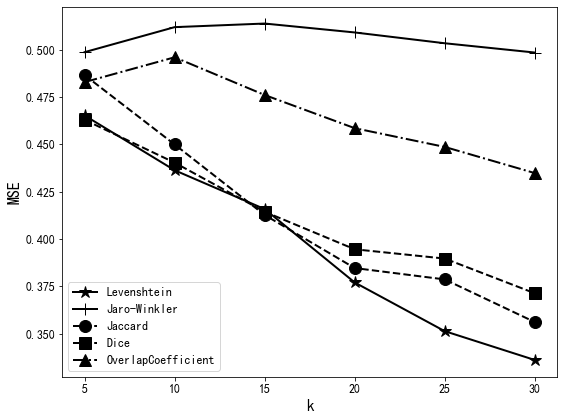

In [70]:
stat_frame = pd.DataFrame(model_k_mse).round(4)

fig, ax3 = plt.subplots(figsize=(8, 6))

ax3.set_xlabel('k')
ax3.set_xticklabels([0, 5, 10, 15, 20, 25, 30])
ax3.set_ylabel('MSE')
# ax3.set_ylabel('Precision')
# ax3.set_ylabel('Recall')

fmts = ['k*-', 'k+-', 'ko--', 'ks--', 'k^-.']
for i, (model_name, _) in enumerate(model_k_recalls.items()):
    y_data = stat_frame[model_name].tolist()
    ax3.plot(y_data, fmts[i], label=model_name, linewidth=2, markersize=12)

ax3.legend()

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/string_match_mse.pdf', format='pdf')
plt.show()

### OverlapCoefficient 在各个 topic 上的召回

In [72]:
model = SM.overlap_coefficient.OverlapCoefficient()

k_range = list(range(10, 35, 5))
k_recalls = dict()
k_precisions = dict()
for k in k_range:
    recalls, precisions = [], []
    for topic, report_ids in test_data.items():
        pairs = []
        for tid, title in id_2_report.items():
            
            score = model.get_sim_score(list(topic), list(title))
            
            pairs.append({'index': tid, 'score': score})
            #
        pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
        count = 0
        for pair in pairs[:k]:
            if pair['index'] in report_ids:
                count += 1
            # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
        recall = count / len(report_ids)
        # print('{} 召回率: {:.4f}'.format(topic, recall))
        recalls.append(recall)
        precision = count / k
        precisions.append(precision)

    # print(m_name, sum(recalls) / len(recalls))
    k_recalls[k] = recalls
    k_precisions[k] = precisions
    
print(k_recalls)

{10: [0.2857142857142857, 0.7142857142857143, 0.8333333333333334, 0.5714285714285714, 0.5, 0.25, 0.5, 0.3333333333333333, 0.5714285714285714, 0.5714285714285714], 15: [0.42857142857142855, 0.8571428571428571, 0.8333333333333334, 0.5714285714285714, 0.6666666666666666, 0.5, 0.625, 0.3333333333333333, 0.7142857142857143, 0.7142857142857143], 20: [0.42857142857142855, 0.8571428571428571, 0.8333333333333334, 0.7142857142857143, 0.6666666666666666, 0.5, 0.625, 0.3333333333333333, 0.7142857142857143, 0.7142857142857143], 25: [0.7142857142857143, 0.8571428571428571, 0.8333333333333334, 0.8571428571428571, 0.6666666666666666, 0.5, 0.875, 0.3333333333333333, 0.7142857142857143, 0.7142857142857143], 30: [0.8571428571428571, 0.8571428571428571, 0.8333333333333334, 1.0, 0.6666666666666666, 0.625, 0.875, 0.3333333333333333, 0.7142857142857143, 0.7142857142857143]}


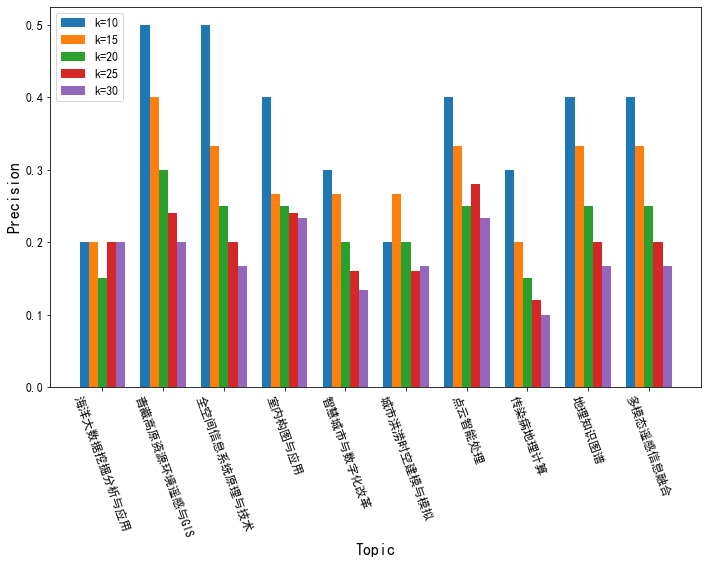

In [73]:
topics = [test_topics[ith] for ith in topic_ids]
topics, recalls

# stat_dict = {
#     'BERT': [0.8571428571428571, 0.7142857142857143, 0.8333333333333334, 0.8571428571428571, 1.0, 0.875, 1.0, 0.6666666666666666, 0.7142857142857143, 0.8571428571428571]
# }

x_labels = topics #[str(i) for i in range(1, len(topic))]
x = np.arange(1, len(x_labels)+1)
width = 0.15

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体

fig, ax1 = plt.subplots(figsize=(10, 8))

data = k_precisions # k_recalls
rects0 = ax1.bar(x-2*width, data[10], width, label='k=10')
rects1 = ax1.bar(x-1*width, data[15], width, label='k=15')
rects2 = ax1.bar(x-0*width, data[20], width, label='k=20')
rects3 = ax1.bar(x+1*width, data[25], width, label='k=25')
rects4 = ax1.bar(x+2*width, data[30], width, label='k=30')

ax1.set_xlabel('Topic')
ax1.set_xticks(np.arange(1, len(topics)+1))
ax1.set_xticklabels(x_labels, rotation=290)
# ax1.set_xticks(x, x_labels)

ax1.set_ylabel('Precision')
#ax1.set_ylabel('Recall')
ax1.legend()


fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/string_match_topic_precisions.pdf', format='pdf')
plt.show()

## 基于词向量的文本相似度计算

In [84]:
from text2vec import Similarity
title_list = list(title_set)
# embedding_type: ['w2v', 'sbert']
# similarity_type: ['cosine', 'wmd']
sim_model = Similarity(similarity_type='cosine', embedding_type='sbert')

sim_model = {
    'Word2Vec': Similarity(similarity_type='cosine', embedding_type='w2v'),
    'SBERT': Similarity(similarity_type='cosine', embedding_type='sbert')
}

model_k_recalls = defaultdict(dict)
model_k_precisions = defaultdict(dict)
model_k_mse = defaultdict(dict)
k_range = list(range(5, 35, 5))

for k in tqdm(k_range):
    for i, (m_name, model) in enumerate(sim_model.items()): # 遍历多个模型
        recalls, precisions = [], []
        for topic, report_ids in test_data.items(): # 遍历各个地理要素
            pairs = []
            for tid, title in id_2_report.items(): # 遍历另一体系下的所有地理要素
                score = model.get_score(topic, title) # 计算相似度
                pairs.append({'index': tid, 'score': score})
                #
            pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
            count = 0
            for pair in pairs[:k]:
                if pair['index'] in report_ids:
                    count += 1
                
            recall = count / len(report_ids)
            recalls.append(recall)
            precision = count / k
            precisions.append(precision)

        # print(m_name, sum(recalls) / len(recalls))
        model_k_recalls[m_name][k] = sum(recalls) / len(recalls)
        model_k_precisions[m_name][k] = sum(precisions) / len(precisions)
        
model_k_recalls = dict(model_k_recalls)
model_k_precisions = dict(model_k_precisions)


  0%|          | 0/6 [00:00<?, ?it/s]2022-02-13 18:43:45.400 | DEBUG    | text2vec.word2vec:__init__:81 - Load w2v from w2v-light-tencent-chinese, spend 1.10 sec
2022-02-13 18:43:45.401 | DEBUG    | text2vec.word2vec:__init__:85 - Word count: 143613, emb size: 200
2022-02-13 18:43:45.402 | DEBUG    | text2vec.word2vec:__init__:86 - Set stopwords: ['--', '?', 'ZT', 'ZZ', "a's", 'able', 'about', 'above', 'according', 'accordingly'], count: 1396
100%|██████████| 6/6 [10:47<00:00, 107.97s/it]


### 画召回率和精度

C:\Users\kobe\.conda\envs\forltp\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


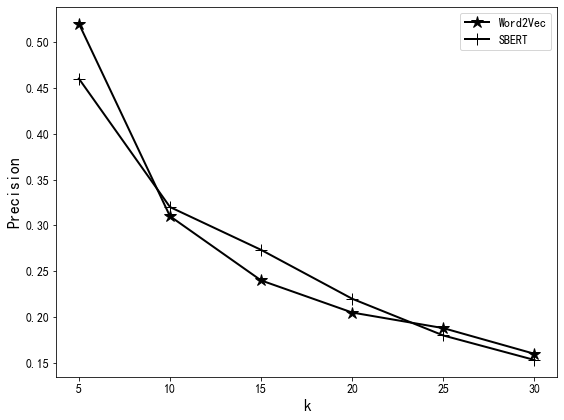

In [86]:
stat_frame = pd.DataFrame(model_k_precisions).round(4)

fig, ax3 = plt.subplots(figsize=(8, 6))

ax3.set_xlabel('k')
ax3.set_xticklabels([0, 5, 10, 15, 20, 25, 30])

ax3.set_ylabel('Precision')
# ax3.set_ylabel('Recall')

fmts = ['k*-', 'k+-', 'ko--', 'ks--', 'k^-.']
for i, (model_name, _) in enumerate(model_k_recalls.items()):
    y_data = stat_frame[model_name].tolist()
    ax3.plot(y_data, fmts[i], label=model_name, linewidth=2, markersize=12)

ax3.legend()

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/word2vec_sim_precisions.pdf', format='pdf')
plt.show()

## 多种排序模型对比

In [ ]:
from text2vec import Similarity

model_k_recalls = defaultdict(dict)
model_k_precisions = defaultdict(dict)
k_range = list(range(5, 35, 5))

## SBERT
model = Similarity(similarity_type='cosine', embedding_type='sbert')
for k in tqdm(k_range):
    
    recalls, precisions = [], []
    for topic, report_ids in test_data.items():
        pairs = []
        for tid, title in id_2_report.items():
            score = model.get_score(topic, title)
            pairs.append({'index': tid, 'score': score})
            #
        pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
        count = 0
        for pair in pairs[:k]:
            if pair['index'] in report_ids:
                count += 1
            # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
        recall = count / len(report_ids)
        # print('{} 召回率: {:.4f}'.format(topic, recall))
        recalls.append(recall)
        precision = count / k
        precisions.append(precision)

    # print(m_name, sum(recalls) / len(recalls))
    model_k_recalls['SBERT'][k] = recalls
    model_k_precisions['SBERT'][k] = precisions

## OverlapCoefficient
model = SM.overlap_coefficient.OverlapCoefficient()
for k in k_range:
    
    recalls, precisions = [], []

    for topic, report_ids in test_data.items():
        pairs = []
        for tid, title in id_2_report.items():
            
            score = model.get_sim_score(list(topic), list(title))
            pairs.append({'index': tid, 'score': score})
            #
        pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
        count = 0
        for pair in pairs[:k]:
            if pair['index'] in report_ids:
                count += 1
            # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
        recall = count / len(report_ids)
        # print('{} 召回率: {:.4f}'.format(topic, recall))
        recalls.append(recall)
        precision = count / k
        precisions.append(precision)


    model_k_recalls['OverlapCoefficient'][k] = recalls
    model_k_precisions['OverlapCoefficient'][k] = precisions

## Interact-BERT
for k in k_range:
    recalls, precisions = [], []
    for ith in topic_ids:
        keyword = test_topics[ith]
        probs = prob_matrix[:, ith]
        ranks = np.argsort(-probs) # 由于默认使用升序，所以使用负号
        #print(keyword, ':')
        gold_report_ids = topic_2_report_id[keyword]
        count = 0
        for i, r in enumerate(ranks[:k]): # 看前十个
            report = sorted_data[r]
            if r in gold_report_ids:
                count += 1
            # print(report['title'], probs[r])
        recall = count / len(gold_report_ids)
        recalls.append(recall)
        precision = count / k
        precisions.append(precision)

    model_k_recalls['Interact-BERT'][k] = recalls
    model_k_precisions['Interact-BERT'][k] = precisions

## Interact-BERT
for k in k_range:
    recalls, precisions = [], []
    for ith in topic_ids:
        keyword = test_topics[ith]
        probs = prob_matrix[:, ith]
        ranks = np.argsort(-probs) # 由于默认使用升序，所以使用负号
        #print(keyword, ':')
        gold_report_ids = topic_2_report_id[keyword]
        count = 0
        for i, r in enumerate(ranks[:k]): # 看前十个
            report = sorted_data[r]
            if r in gold_report_ids:
                count += 1
            # print(report['title'], probs[r])
        recall = count / len(gold_report_ids)
        recalls.append(recall)
        precision = count / k
        precisions.append(precision)

    model_k_recalls['Interact-BERT'][k] = recalls
    model_k_precisions['Interact-BERT'][k] = precisions

### 画整体图

C:\Users\kobe\.conda\envs\forltp\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


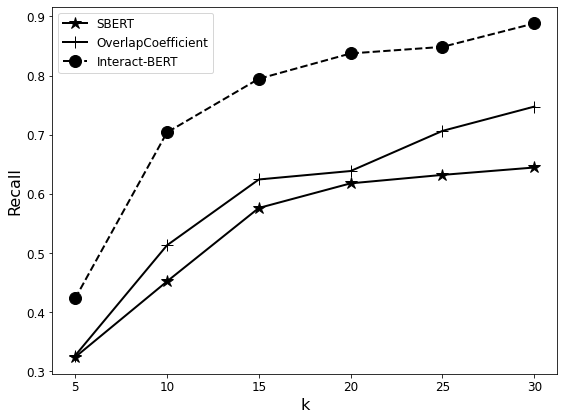

In [35]:
data = model_k_recalls

fig, ax3 = plt.subplots(figsize=(8, 6))

ax3.set_xlabel('k')
ax3.set_xticklabels([0, 5, 10, 15, 20, 25, 30])

ax3.set_ylabel('Recall')
# ax3.set_ylabel('Recall')

fmts = ['k*-', 'k+-', 'ko--', 'ks--', 'k^-.']
for i, (model_name, _) in enumerate(model_k_recalls.items()):
    y_data = [sum(v) / len(v) for k, v in data[model_name].items()]
    ax3.plot(y_data, fmts[i], label=model_name, linewidth=2, markersize=12)

ax3.legend()

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/compare_recalls.pdf', format='pdf')
plt.show()

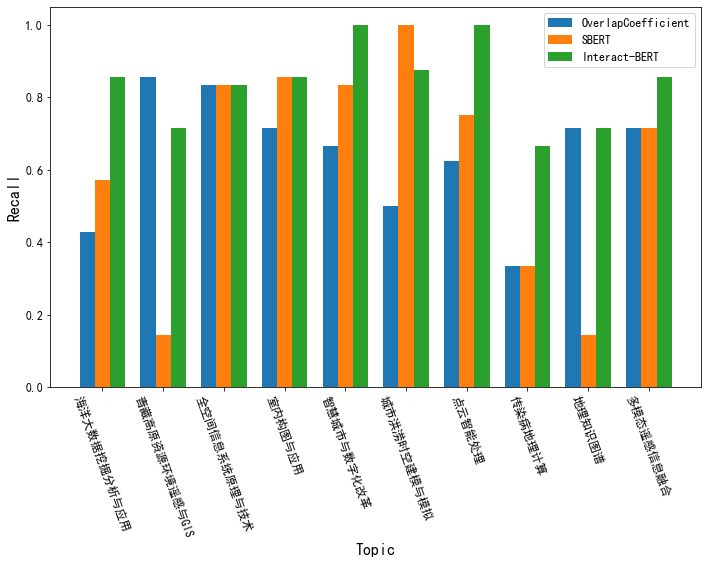

In [38]:
topics = [test_topics[ith] for ith in topic_ids]


x_labels = topics #[str(i) for i in range(1, len(topic))]
x = np.arange(1, len(x_labels)+1)
width = 0.25

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体

fig, ax1 = plt.subplots(figsize=(10, 8))

data = model_k_recalls # k_recalls
# rects0 = ax1.bar(x-2*width, data[10], width, label='k=10')
rects1 = ax1.bar(x-1*width, data['OverlapCoefficient'][20], width, label='OverlapCoefficient')
rects2 = ax1.bar(x-0*width, data['SBERT'][20], width, label='SBERT')
rects3 = ax1.bar(x+1*width, data['Interact-BERT'][20], width, label='Interact-BERT')
# rects4 = ax1.bar(x+2*width, data[30], width, label='k=30')

ax1.set_xlabel('Topic')
ax1.set_xticks(np.arange(1, len(topics)+1))
ax1.set_xticklabels(x_labels, rotation=290)
# ax1.set_xticks(x, x_labels)

#ax1.set_ylabel('Precision')
ax1.set_ylabel('Recall')
ax1.legend()


fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/compare_topic_recalls.pdf', format='pdf')
plt.show()

## BERT-CRF 预测 -> 词云

In [11]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体

file_path = 'data/conference/bert_crf_bert_wwm_ext_12_prediction_conference.jl'
predictions = []
kw_set = set()
with open(file_path, mode='r', encoding='utf-8') as writer:
    for i, line in enumerate(writer):
        data = json.loads(line.strip())
        kws = data['keywords']
        kws = kws.get('keyword', [])
        kw_set.update(kws)
print(len(kw_set))       

885


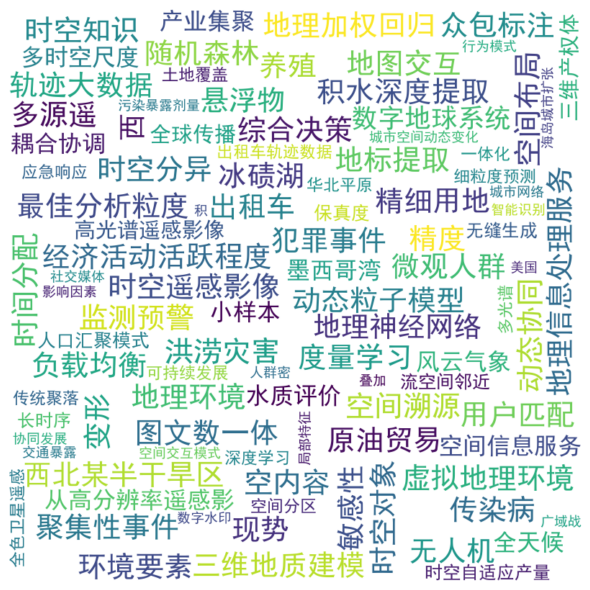

In [21]:
text = ' '.join(list(kw_set))
font_path = 'E:/PythonProjects/wordcloud/SimHei.ttf'
# text = "Are you someone who loves finding and discovering new words? Are you a board game enthusiast? If you are, then this Word Finder is a tool you can't afford not to have. Whether you are into playing Scrabble, Words with Friends or any other word game, Word Finder will prove to be useful. It will help you both with word discovery, and as a reference tool, you and your playmates can use as a way to settle disputes about the validity of any particular word. Do you love boosting your vocabulary? Do word games help ignite your brain cells? Do you enjoy the thrill of trying to outwit an opponent with your encyclopedic mind? Then, our word generator is a tool that you simply can't live without!"
wordcloud = WordCloud(
    width=800,
    height=800,
    max_words=100,
    font_path=font_path,
    max_font_size=40,
    background_color='white').generate(text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('outputs/text_match/figs/wordcloud.pdf', format='pdf')
plt.show()